In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
train_data_file = "/content/gdrive/My Drive/PITE/data.csv"
data = pd.read_csv(train_data_file).sample(100000)
features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value", "seed_p",
                     "seed_nbIT", "seed_tx", "seed_ty"], axis=1).astype(np.float64)
y = data.is_downstream_reconstructible.values
X = features.drop(features.columns[0], axis=1).values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

**RandomForestClassifier**

In [0]:
RFC = RandomForestClassifier(36)

In [0]:
RFC.fit(X_train, y_train)
pred_RFC = RFC.predict(X_test)

In [7]:
print(classification_report(y_test, pred_RFC))
print(confusion_matrix(y_test, pred_RFC))


              precision    recall  f1-score   support

       False       0.82      0.73      0.77      9227
        True       0.79      0.86      0.82     10773

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000

[[6705 2522]
 [1471 9302]]


In [0]:
proba = RFC.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])

In [0]:
def plot_roc(fpr, tpr):
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

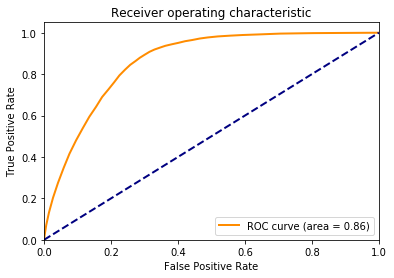

In [48]:
plot_roc(fpr, tpr)

In [0]:
param_grid = {
    'max_depth': [80, 110, None],
    'max_features': [3, "auto"],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 8],
    'n_estimators': [30,  40, 50, 60]
}
RFCGS = RandomForestClassifier()

In [0]:
grid_search = GridSearchCV(estimator = RFCGS, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [0]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))

In [26]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 36.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [43]:
grid_search.best_params_

{'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 40}

In [35]:
best_grid = grid_search.best_estimator_
evaluate(best_grid, X_test, y_test)

              precision    recall  f1-score   support

       False       0.84      0.72      0.77      9227
        True       0.78      0.89      0.83     10773

    accuracy                           0.81     20000
   macro avg       0.81      0.80      0.80     20000
weighted avg       0.81      0.81      0.81     20000



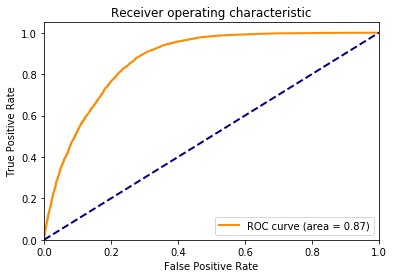

In [49]:
proba = best_grid.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])
plot_roc(fpr, tpr)

In [0]:
RFCRS = RandomForestClassifier()
random_grid = {
    'criterion': "entropy",
    'max_depth': [30, 40, 60, 80, 110, None],
    'max_features': [3, 4, 2,  None, "auto"],
    'min_samples_leaf': [1, 4, 2, 3, 5],
    'min_samples_split': [2, 5, 8, 12],
    'n_estimators': [30, 35, 40, 45, 50, 60, 80]
}

In [0]:
random_search = RandomizedSearchCV(estimator = RFCRS, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [31]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 17.8min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 34.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [42]:
random_search.best_params_

{'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 80}

In [39]:
best_grid_random = random_search.best_estimator_
evaluate(best_grid, X_test, y_test)

              precision    recall  f1-score   support

       False       0.84      0.72      0.77      9227
        True       0.78      0.89      0.83     10773

    accuracy                           0.81     20000
   macro avg       0.81      0.80      0.80     20000
weighted avg       0.81      0.81      0.81     20000



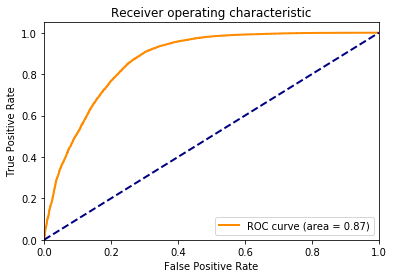

In [50]:
proba = best_grid_random.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])
plot_roc(fpr, tpr)